In [1]:
import numpy as np
import pandas as pd

# tqdm provides responsive progress bars for notebooks.
from tqdm import tqdm_notebook

# For displaying sample images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

# preprocessing
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing import image

# CNN construction
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Transfer Learning
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

# Model Training
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# For filesystem operations in saving augmented data to disk
import shutil
import os
import random

# For Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools 

# For Prediction
from glob import glob

Using TensorFlow backend.


In [2]:
data = load_files('C:/Users/Bhanushree/Downloads/assignment july/plant seedlings classification/labeled', load_content=False, shuffle=True, random_state=42)

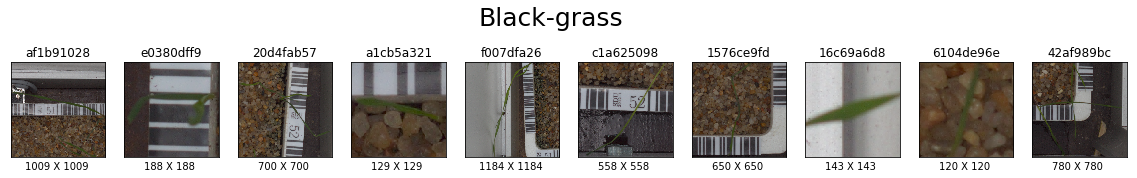

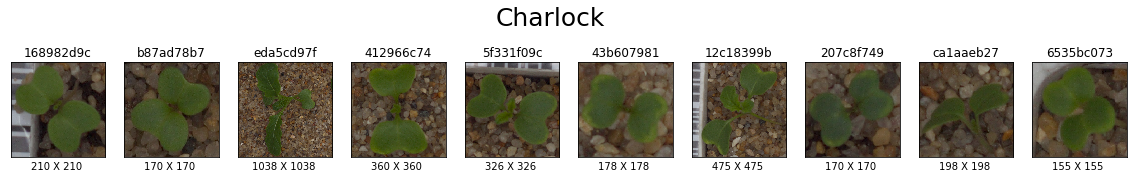

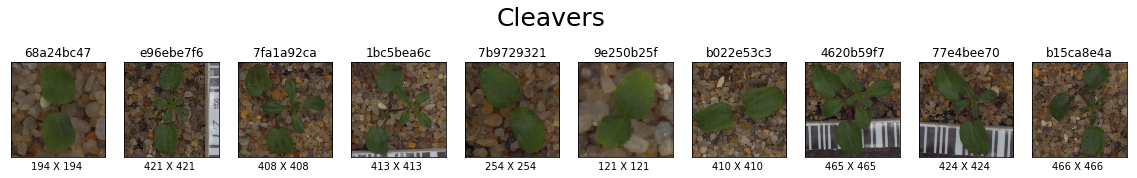

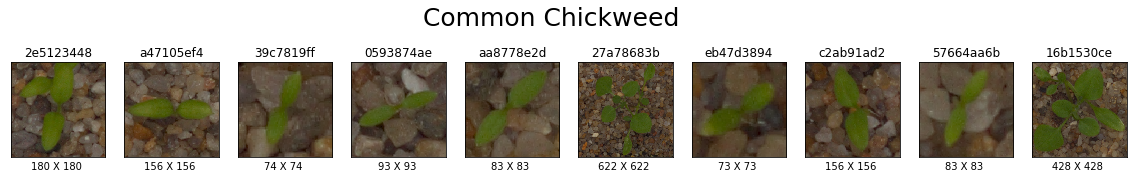

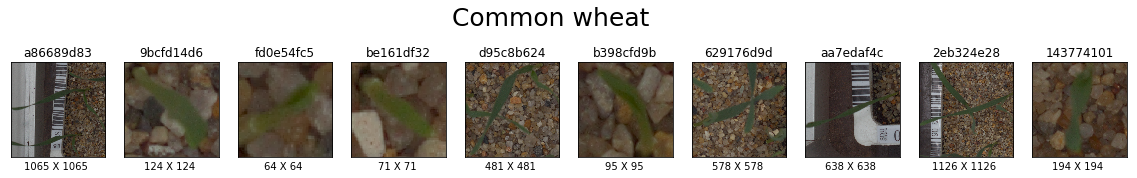

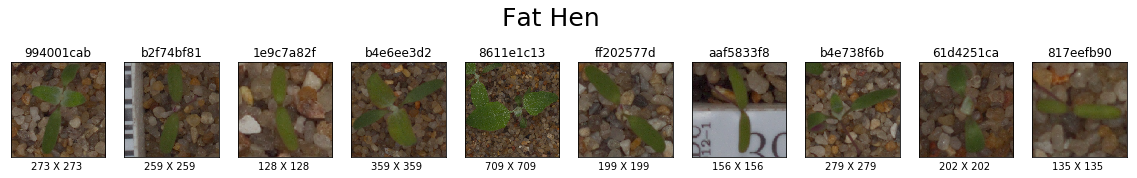

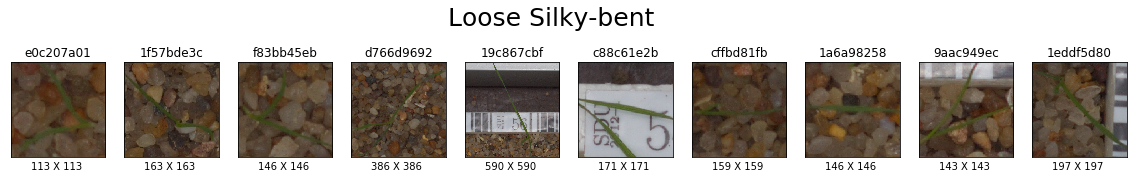

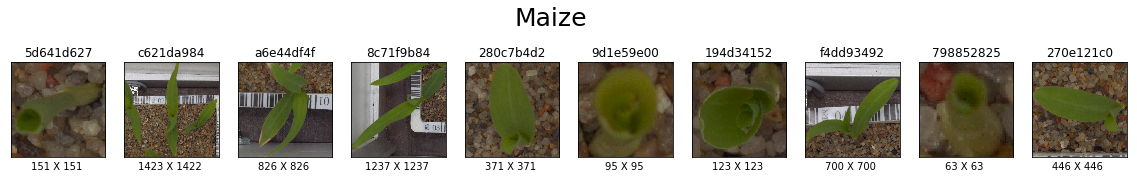

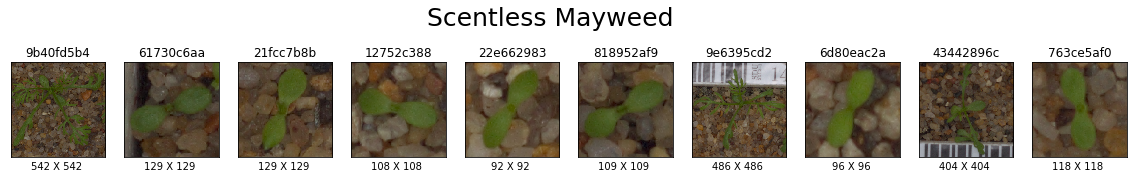

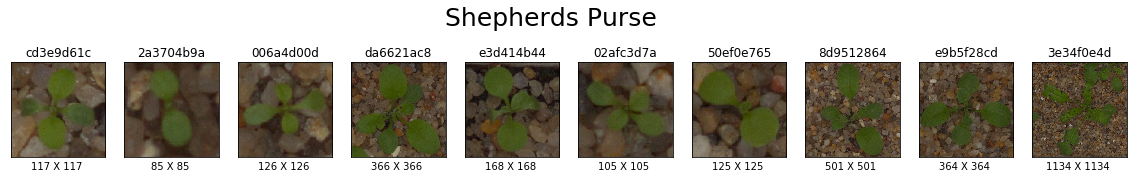

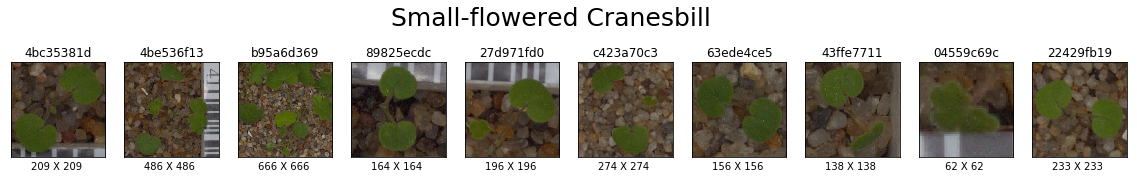

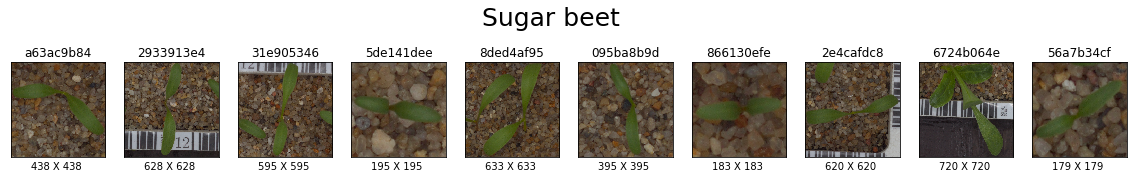

In [3]:
def display_image_samples(n=10):
    for seedling_id in range(12):
        fig = plt.figure(figsize=(20,3))
        fig.suptitle(data['target_names'][seedling_id], fontsize=25)
        imgs = [i for i, j in enumerate(data['target']) if j == seedling_id]
        for i in range(n):
            seedling_file = data['filenames'][imgs[i]]
            with Image.open(seedling_file) as img:
                width, height = img.size
                ax = fig.add_subplot(1, n, i+1, xticks=[], yticks=[])
                ax.imshow(mpimg.imread(seedling_file))
                ax.set_title(seedling_file[-13:-4])
                ax.set_xlabel("%d X %d " % (width, height))
        plt.show()

display_image_samples()

In [4]:
def extract_test_and_train(data, perc_test = 0.1):
    x = np.array(data['filenames'])
    y = np.array(data['target'])
    labels = np.array(data['target_names'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=perc_test, random_state=42)
    return x_train, x_test, y_train, y_test, labels

x_train, x_test, y_train, y_test, labels = extract_test_and_train(data)

In [5]:
#Load Training and Test Images into Tensors

In [6]:
def to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0).astype('float32')/255

def to_tensors(img_paths):
    list_of_tensors = [to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_tensors)

# make tensors from x_train and x_test
x_train_tensors = to_tensors(x_train)
x_test_tensors = to_tensors(x_test)

In [7]:
#One Hot Encode Targets
y_train_targets = np_utils.to_categorical(y_train, 12)
y_test_targets = np_utils.to_categorical(y_test, 12)

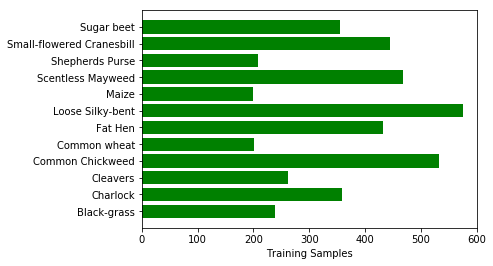

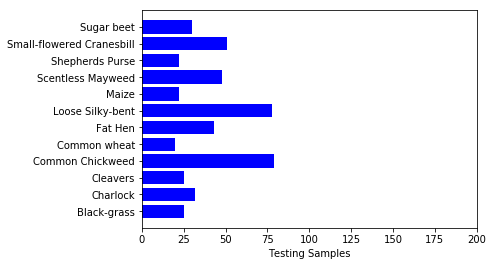

In [8]:
#Plot Class Distribution
def plot_class_distribution(targets, title, xlim, bar_color, labels):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))
    train_labels = np.sum(targets, axis=0)
    ax.barh(y_pos, train_labels, align='center', color=bar_color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel(title)
    ax.set_xlim(0, xlim)
    plt.show()

    
plot_class_distribution(y_train_targets, 'Training Samples', 600, 'green', labels)
plot_class_distribution(y_test_targets, 'Testing Samples', 200, 'blue', labels)

In [11]:
datagen = image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def augment_and_oversample(x_train_tensors, y_train, labels, n = 2000):
    # empty the augmented folder
    if os.path.isdir('C:/Users/Bhanushree/Downloads/assignment july/plant seedlings classification/augmented'): 
        shutil.rmtree('C:/Users/Bhanushree/Downloads/assignment july/plant seedlings classification/augmented')
    os.makedirs('C:/Users/Bhanushree/Downloads/assignment july/plant seedlings classification/augmented')
    # for each of the unique seedling ids
    for seedling_id in range(12):
        # create a folder in augmented for the seedling
        print('Augmenting training data for %s' % labels[seedling_id])
        directory_for_images = 'C:/Users/Bhanushree/Downloads/assignment july/plant seedlings classification/augmented/%s' % labels[seedling_id]
        os.makedirs(directory_for_images)
        imgs = [i for i, j in enumerate(y_train) if j == seedling_id]
        random.shuffle(imgs)
        # pad imgs list to be of length n
        imgs = (imgs * (n // len(imgs))) + imgs[0:n % len(imgs)]        
        # create n new tensors, iterating through all the matching tensors in x_train
        n_imgs = x_train_tensors[imgs]
        for batch in datagen.flow(n_imgs, batch_size=n, save_to_dir=directory_for_images, save_format='png'):
            break

# Once the augmented data is created, it's not necessary to recreate it again. 

# The next line is commented out to avoid unnecessarily recreating the augmented data which takes ~ 30 minutes

#augment_and_oversample(x_train_tensors, y_train, labels)

In [14]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [15]:
basic_cnn = Sequential()
basic_cnn.name = 'basic_cnn'

### TODO: Define your architecture.
basic_cnn.add(Conv2D(16, kernel_size=2, strides=1, input_shape=(224,224,3)))
basic_cnn.add(MaxPooling2D(pool_size=2))
basic_cnn.add(Conv2D(32, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))
basic_cnn.add(Conv2D(64, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added these two layers to the hinted solution
basic_cnn.add(Conv2D(128, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added additional layers to the hinted solution
basic_cnn.add(Conv2D(256, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added additional layers to the hinted solution
basic_cnn.add(Conv2D(512, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

basic_cnn.add(GlobalAveragePooling2D())
basic_cnn.add(Dense(12, activation='softmax'))
basic_cnn.summary()

basic_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv

In [16]:
last_layer_to_freeze = 10

vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# freeze all the existing layers
for layer in vgg_model.layers[:last_layer_to_freeze]:
   layer.trainable = False

# adding custom Layers 
x = vgg_model.output
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

# creating the final model 
vgg_based_cnn = Model(input = vgg_model.input, output = predictions)
vgg_based_cnn.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[f1])
vgg_based_cnn.name = 'vgg_based_cnn'

80142336/80134624 [==============================] - ETA:  - ETA: 11:5 - ETA: 10:2 - ETA: 7:1 - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 1: - ETA: 51s - ETA: 51 - ETA: 53 - ETA: 47 - ETA: 46 - ETA: 48 - ETA: 42 - ETA: 42 - ETA: 43 - ETA: 40 - ETA: 40 - ETA: 41 - ETA: 37 - ETA: 37 - ETA: 38 - ETA: 36 - ETA: 35 - ETA: 36 - ETA: 35 - ETA: 33 - ETA: 34 - ETA: 32 - ETA: 32 - ETA: 33 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 29 - ETA: 30 - ETA: 30 - ETA: 28 - ETA: 28 - ETA: 29 - ETA: 27 - ETA: 27 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ET

C:\Users\Bhanushree\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [17]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def train(model, epochs=5, x=x_train_tensors, y=y_train_targets, validate_using_test_set = True):
    checkpointer = ModelCheckpoint(filepath="saved_models/weights.best.from_%s.hdf5" % model.name, 
                               verbose=1, save_best_only=True)
    if validate_using_test_set:
        model.fit(x, y, 
              validation_data=(x_test_tensors, y_test_targets),
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
    else:
        model.fit(x, y, 
              validation_split=0.2, shuffle=True,
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [19]:
"""
Evaluate the results of a model.
The F1 Score for the Test Sample is displayed. 
A confusion matrix showing all True Positives, False Negatives and False Positives is displayed. 
"""

def evaluate(model):
    model.load_weights("saved_models/weights.best.from_%s.hdf5" % model.name)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test_tensors]
    y_true = np.argmax(y_test_targets, axis=1)

    f1 = f1_score(y_true, y_pred, average='micro')
    print('Test F1 Score: %.5f' % f1)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix')
    plt.show()

In [20]:
def predict(model):
    unlabeled_files = glob("data/unlabeled/*")
    unlabeled_tensors = to_tensors(unlabeled_files)
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in unlabeled_tensors]

    file_names = [x[15:] for x in unlabeled_files]
    df = pd.DataFrame(index=file_names, data=labels[predictions])
    df.to_csv("predictions/predictions_from_%s.csv" % model.name)

In [21]:
#Choose model, train, evaluate and predict
model = basic_cnn

n_epochs = 10

train(model, epochs=n_epochs, validate_using_test_set=True)
#train(model, epochs=n_epochs, validate_using_test_set=False, x = x_augmented_tensors, y = y_augmented_targets)
evaluate(model)
predict(model)

Instructions for updating:
Use tf.cast instead.
Train on 4275 samples, validate on 475 samples
Epoch 1/10
4275/4275 [==============================] - ETA: 23:48 - loss: 2.4865 - f1: n - ETA: 15:26 - loss: 2.8349 - f1: n - ETA: 12:12 - loss: 3.1155 - f1: n - ETA: 11:04 - loss: 3.1932 - f1: n - ETA: 9:57 - loss: 3.1375 - f1: nan - ETA: 9:25 - loss: 3.0444 - f1: na - ETA: 9:00 - loss: 2.9554 - f1: na - ETA: 8:38 - loss: 2.8833 - f1: na - ETA: 8:38 - loss: 2.8553 - f1: na - ETA: 8:25 - loss: 2.8110 - f1: na - ETA: 8:24 - loss: 2.7680 - f1: na - ETA: 8:10 - loss: 2.7298 - f1: na - ETA: 7:56 - loss: 2.7010 - f1: na - ETA: 7:46 - loss: 2.6843 - f1: na - ETA: 7:36 - loss: 2.6653 - f1: na - ETA: 7:28 - loss: 2.6442 - f1: na - ETA: 7:20 - loss: 2.6188 - f1: na - ETA: 7:12 - loss: 2.6053 - f1: na - ETA: 7:06 - loss: 2.5883 - f1: na - ETA: 7:01 - loss: 2.5739 - f1: na - ETA: 6:52 - loss: 2.5534 - f1: na - ETA: 6:45 - loss: 2.5440 - f1: na - ETA: 6:40 - loss: 2.5293 - f1: na - ETA: 6:36 - loss: 2.

OSError: Unable to create file (unable to open file: name = 'saved_models/weights.best.from_basic_cnn.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

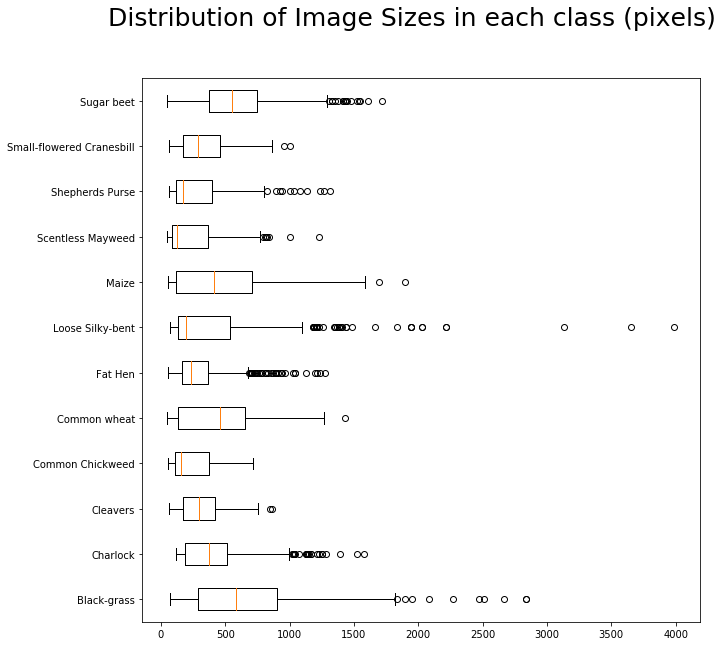

In [23]:
def display_image_size_distribution():
    widths_for_each_class = []
    for seedling_id in range(12):
        imgs = [i for i, j in enumerate(data['target']) if j == seedling_id]
        widths = [Image.open(data['filenames'][i]).width for i in imgs]
        widths_for_each_class.append(widths)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Distribution of Image Sizes in each class (pixels)", fontsize=25)
    plt.boxplot(widths_for_each_class, vert=False, labels=data['target_names'])
    plt.show()

display_image_size_distribution()
